In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.dt_helpers.network_dynamics import compute_individual_neuron_frequency

# Phase analysis

Network activity defined by:

$$ \tau \frac{\mathrm{d}h}{\mathrm{d}t} = -h + \phi(W h + I) \Rightarrow h_{t+\mathrm{d}t} - h_t = \alpha(-h_t + \phi(W h_t + I)) \Rightarrow h_{t+\mathrm{d}t} = (1 - \alpha + \alpha g W) h_t + \alpha g I$$

where $\alpha = \mathrm{d}t / \tau$, and $g$ is the non-linearity gain at time $t$, potentially different for each neuron (column-wise multiplication with $W$).

Decompose the $W^* \equiv 1 - \alpha + \alpha g W$ matrix by eigendecomposition and denote vectors in those directions by hat $\widehat{\cdot}$. Then:

$$\widehat{h_{t + \mathrm{d}t}} = D^* \widehat{h_t} + \alpha g \widehat{I}$$

where $D^*$ is the diagonal form of $W^*$ with eigenvalues $\lambda^*$ depending on eigenvalues $\lambda \equiv a + \mathrm{i} b$ of $W$ by $\lambda^* = 1 - \alpha + \alpha g \lambda$.

Assuming gain is constant $g$ for all neurons, the hidden state in eigendirection $i$ at time $k \mathrm{d}t$ is:

$$\widehat{h_{k,i}} = \alpha g \widehat{I_i} \frac{\lambda_i^*{}^k - 1}{\lambda_i^* - 1}.$$

We are interested in the phase of $\widehat{h_{k,i}}$. Let $\lambda^* \equiv a^* + \mathrm{i} b^* \equiv r^* e^{\mathrm{i} \theta^*}$, where $\theta^* = \mathrm{atan2}(b^*, a^*) \approx b^* / a^* = \frac{\alpha g b}{1 - \alpha + \alpha g a}$, since $\alpha \ll 1$.

Phase of $\widehat{h_{k,i}}$ is given by Im and Re parts of it (assume input projection is positive for simplicity):
\begin{align*}
\varphi(\widehat{h_{k,i}}) &= \mathrm{atan2}(Im(\widehat{h_{k,i}}), Re(\widehat{h_{k,i}})) = \\
&= \mathrm{atan2}\left([Im, Re]\left(\alpha g \widehat{I_i} \frac{\lambda_i^*{}^k - 1}{\lambda_i^* - 1}\right)\right) = \\
&= \mathrm{atan2}\left([Im, Re]\left(\frac{\lambda_i^*{}^k - 1}{\lambda_i^* - 1}\right)\right) = \\
&= \mathrm{atan2}\left([Im, Re]\left((\lambda_i^*{}^k - 1) (\bar{\lambda_i^*} - 1)\right)\right) = \\
&= \mathrm{atan2}\left([Im, Re]\left((r^*{}^k e^{\mathrm{i}k\theta^*} - 1) (r^*{} e^{-\mathrm{i}\theta^*} - 1)\right)\right) = \\
&= \mathrm{atan2}\left([Im, Re]\left((r^*{}^{k+1} e^{\mathrm{i}(k-1)\theta^*} - r^*{} e^{-\mathrm{i}\theta^*} - r^*{}^k e^{\mathrm{i}k\theta^*} + 1\right)\right)
\end{align*}

In [3]:
# init variables
tau_s = 20e-3
dt_s = 1e-5
lambda_0 = 1.0 + 1.91106156j
duration_taus = 100
num_scales = 31
max_scale_factor = 0.5
min_g = 0.5
max_g = 1.0
alpha = dt_s / tau_s
num_steps = int(duration_taus / alpha)

# rescale lambda such that lambda_star (for g=1 and scale=1) has radius 1
a = lambda_0.real
b = lambda_0.imag
rescale_plus = (a * (alpha - 1) + np.sqrt(a**2 - (alpha - 2) * alpha * b**2)) / (alpha * (a**2 + b**2))
rescale_minus = (a * (alpha - 1) - np.sqrt(a**2 - (alpha - 2) * alpha * b**2)) / (alpha * (a**2 + b**2))
rescale_factor = 1
if rescale_plus * rescale_minus < 0:
    rescale_factor = np.maximum(rescale_plus, rescale_minus)
else:
    raise ValueError("Both rescale factors have the same sign")
lambda_0 = lambda_0 * rescale_factor
lambda_star_0 = 1 - alpha + alpha * lambda_0
print("Effective eigenval (lambda_star) magnitude: ", np.abs(lambda_star_0))

a = lambda_0.real
b = lambda_0.imag
g = np.linspace(min_g, max_g, num_scales)
eig_rescale = 1 + np.linspace(-max_scale_factor, max_scale_factor, num_scales)
lambda_star = 1 - alpha + alpha * g * (a + 1j * b) * eig_rescale[:, np.newaxis]
ks = np.arange(num_steps)[:, np.newaxis, np.newaxis]
h_ki = alpha * g * (np.power(lambda_star, ks) - 1) / (lambda_star - 1)
h_ki_angle = np.angle(h_ki)

Effective eigenval (lambda_star) magnitude:  1.0


Simulation of phase of $h_{k,i}$ for gain $g=1$ and eigenvalue radius scale $=1$

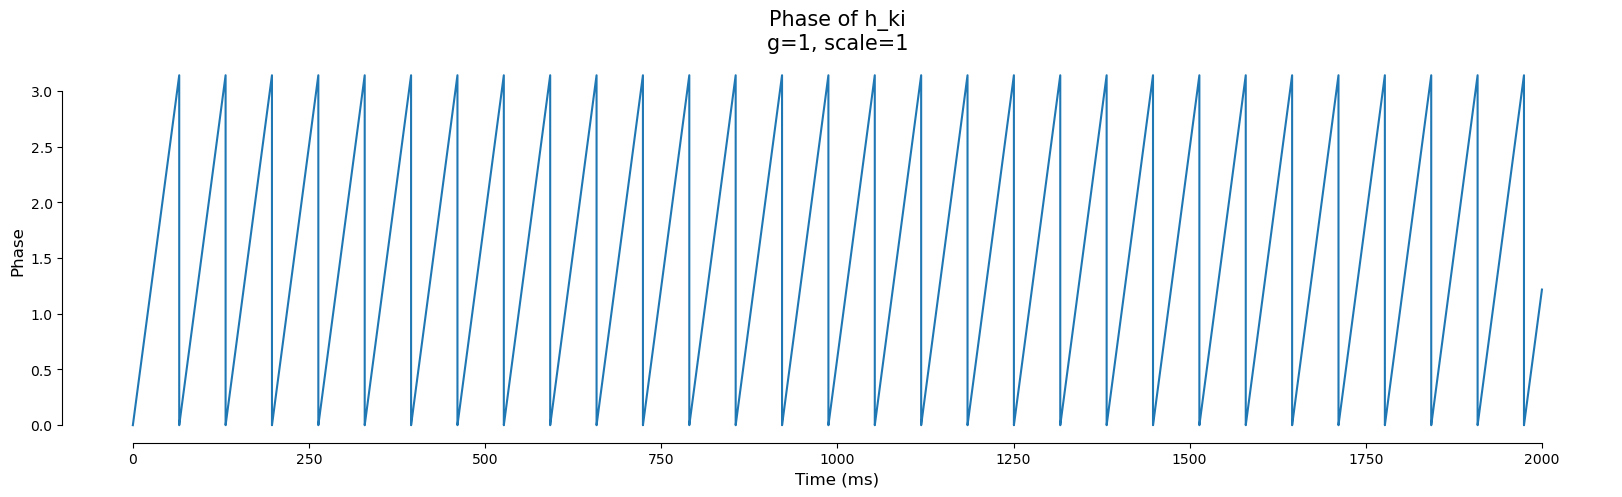

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(num_steps) * dt_s * 1e3, h_ki_angle[:, num_scales // 2, -1])
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Phase", fontsize=12)
plt.title("Phase of h_ki\ng=1, scale=1", fontsize=15)
sns.despine(offset=0, trim=True)
plt.show()

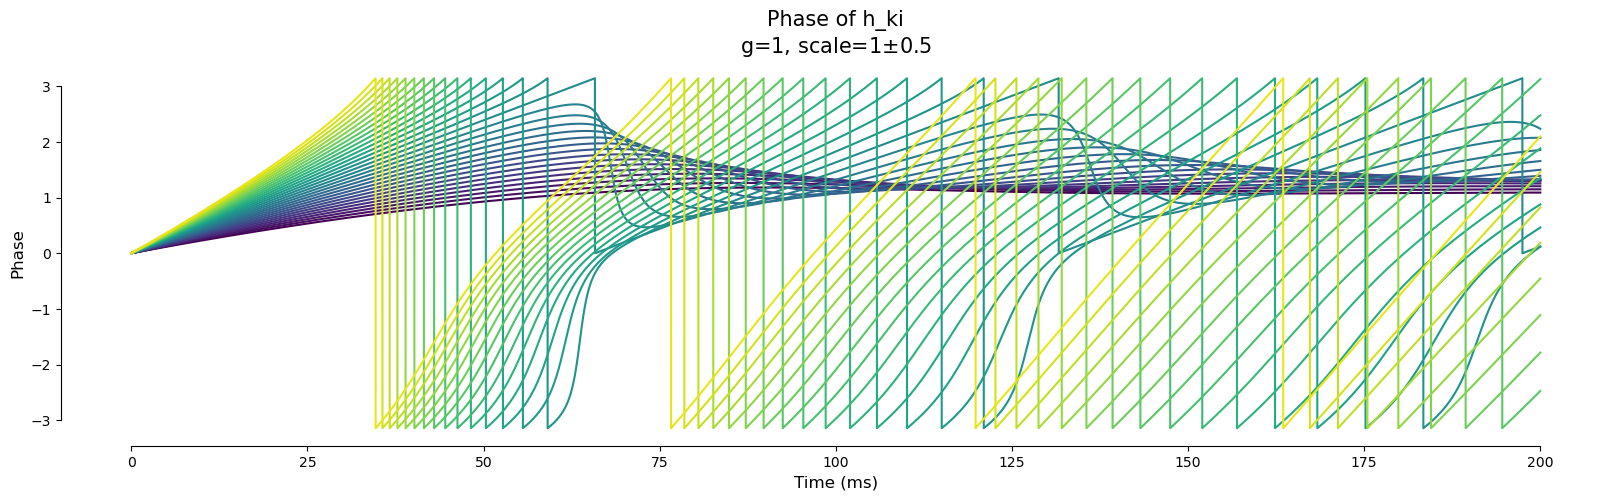

In [5]:
plt.figure(figsize=(20, 5))
for i, scale in enumerate(eig_rescale):
    plt.plot(np.arange(num_steps)[:int(10 / alpha)] * dt_s * 1e3, np.angle(h_ki[:, i, -1])[:int(10 / alpha)], color=plt.cm.viridis(i / num_scales))
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Phase", fontsize=12)
plt.title("Phase of h_ki\ng=1, scale=1"r"$\pm$"f"{max_scale_factor}", fontsize=15)
sns.despine(offset=0, trim=True)
plt.show()

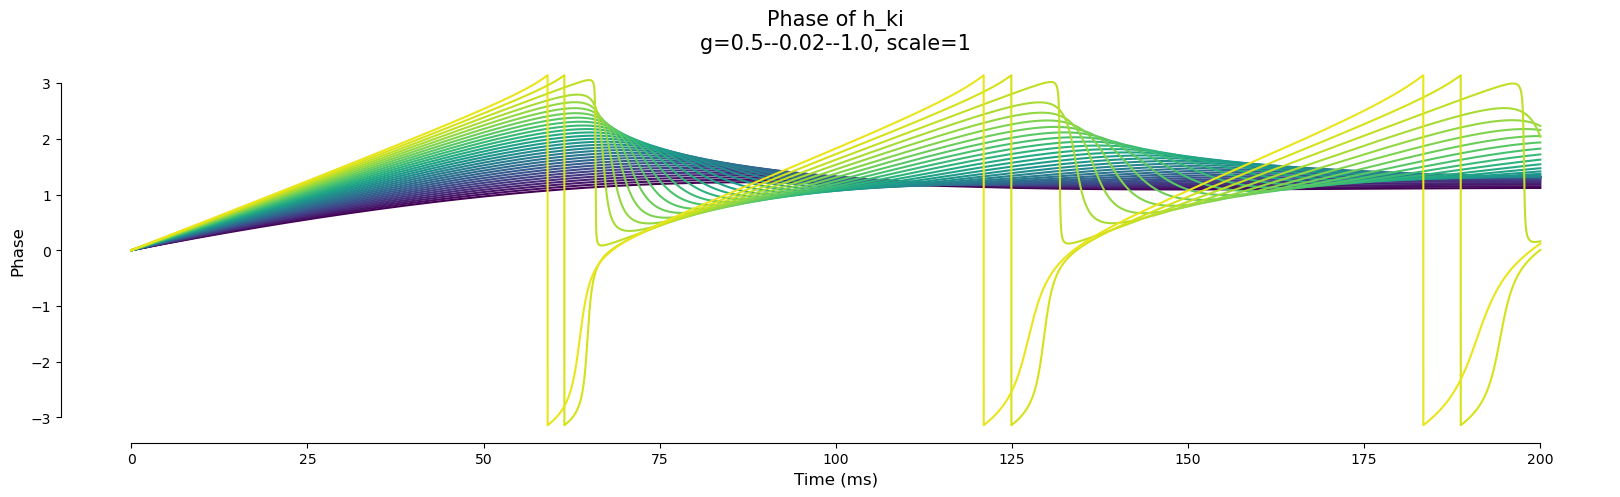

In [6]:
plt.figure(figsize=(20, 5))
for i, g_val in enumerate(g):
    plt.plot(np.arange(num_steps)[:int(10 / alpha)] * dt_s * 1e3, np.angle(h_ki[:, num_scales//2+1, i])[:int(10 / alpha)], color=plt.cm.viridis(i / num_scales))
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Phase", fontsize=12)
plt.title(f"Phase of h_ki\ng={g[0]}--{g[1]-g[0]:.2f}--{g[-1]}, scale=1", fontsize=15)
sns.despine(offset=0, trim=True)
plt.show()

In [7]:
temp_indi_freq = compute_individual_neuron_frequency(
    h_ki_angle.reshape(h_ki_angle.shape[0], -1), dt=dt_s, num_steps=num_steps, max_frequency=100, use_interpolation=True
)
temp_indi_freq = np.array(list(temp_indi_freq.values())).reshape(h_ki_angle.shape[1], h_ki_angle.shape[2])

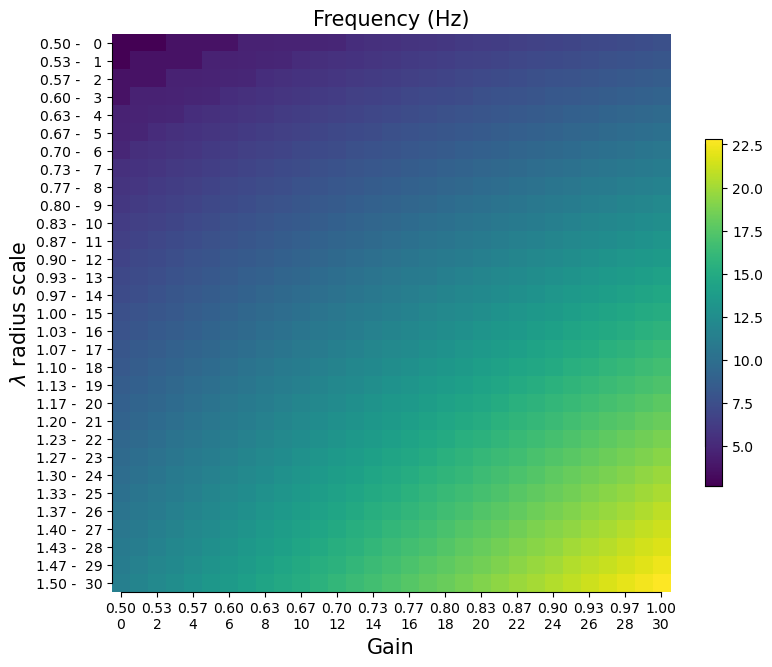

In [8]:
plt.figure(figsize=(9, 9))
plt.imshow(temp_indi_freq)
plt.xlabel("Gain", fontsize=15)
plt.ylabel(r"$\lambda$ radius scale", fontsize=15)
plt.title("Frequency (Hz)", fontsize=15)
plt.colorbar(shrink=0.5)
plt.xticks(np.arange(len(g))[::2], [f"{x:.2f}\n{i}" for i, x in enumerate(g)][::2])
plt.yticks(np.arange(len(eig_rescale)), [f"{x:.2f} -  {str(i).rjust(2)}" for i, x in enumerate(eig_rescale)])
sns.despine(offset=0, trim=True)
plt.show()

1.0 [0.96666667 0.98333333 1.        ]


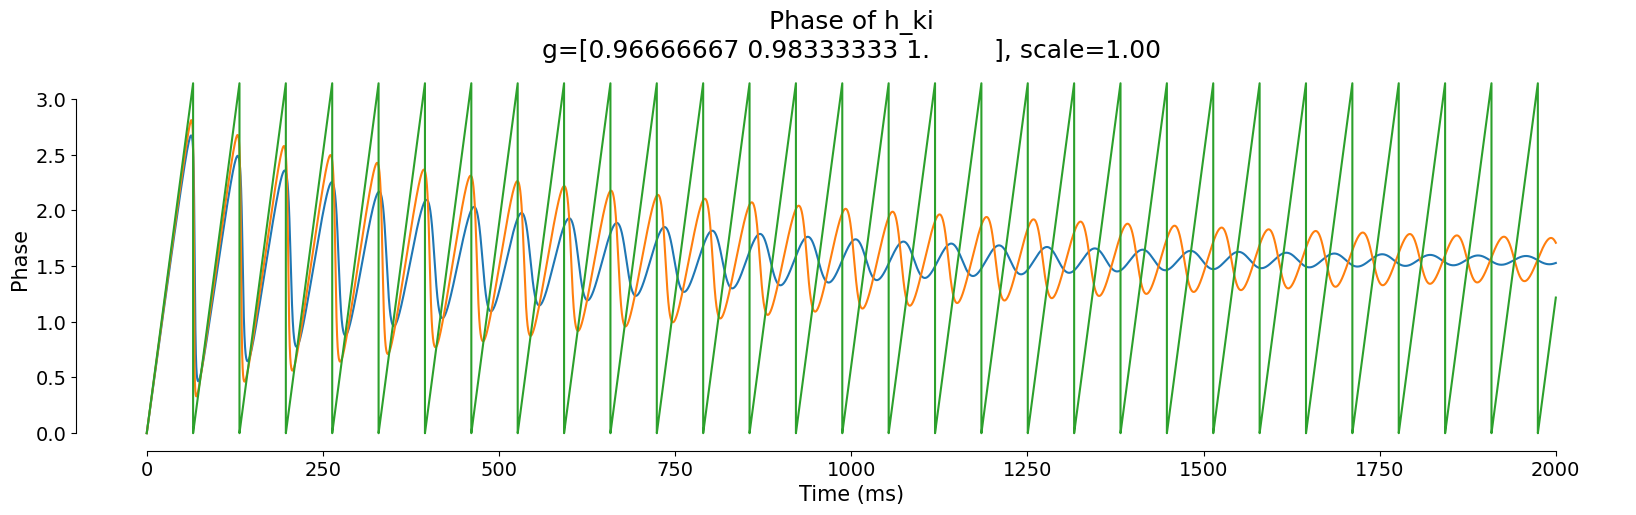

In [9]:
id_scale = 15
id_g = [28, 29, 30]

print(eig_rescale[id_scale], g[id_g])

plt.figure(figsize=(20, 5))
plt.plot(np.arange(num_steps) * dt_s * 1e3, h_ki_angle[:, id_scale, id_g])
plt.xlabel("Time (ms)", fontsize=15)
plt.ylabel("Phase", fontsize=15)
plt.title(f"Phase of h_ki\ng={g[id_g]}, scale={eig_rescale[id_scale]:.2f}", fontsize=18)
sns.despine(offset=0, trim=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Compare expected frequency (given by $\theta / (2 \pi \mathrm{d}t$) to the observed frequency estimated above

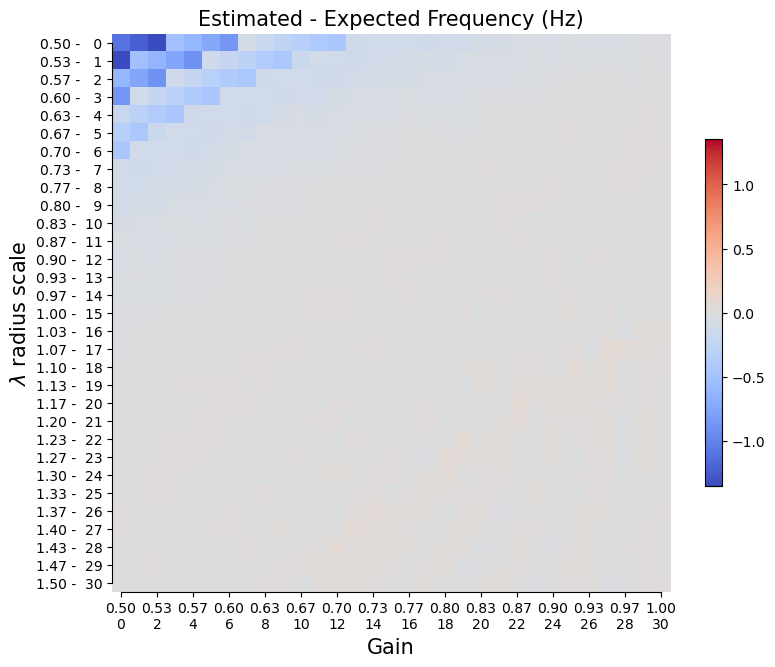

In [10]:
expected_freq = np.angle(lambda_star) / (2 * np.pi * dt_s)
freq_diff = temp_indi_freq - expected_freq
vval = np.max(np.abs(freq_diff))
# vval = np.max(np.abs(np.log10(np.abs(freq_diff)) * np.sign(freq_diff)))
plt.figure(figsize=(9, 9))
plt.imshow(freq_diff, vmin=-vval, vmax=vval, cmap="coolwarm")
# plt.imshow(np.log10(np.abs(freq_diff)) * np.sign(freq_diff), vmin=-vval, vmax=vval, cmap="coolwarm")
plt.xlabel("Gain", fontsize=15)
plt.ylabel(r"$\lambda$ radius scale", fontsize=15)
plt.title("Estimated - Expected Frequency (Hz)", fontsize=15)
plt.colorbar(shrink=0.5)
plt.xticks(np.arange(len(g))[::2], [f"{x:.2f}\n{i}" for i, x in enumerate(g)][::2])
plt.yticks(np.arange(len(eig_rescale)), [f"{x:.2f} -  {str(i).rjust(2)}" for i, x in enumerate(eig_rescale)])
sns.despine(offset=0, trim=True)
plt.show()

In [11]:
np.abs(freq_diff).min()

np.float64(1.1078085613291933e-06)

In [12]:
freq_diff[15,-1]

np.float64(-0.019031191413036552)